In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

import keras_gpu_metrics

In [2]:
from gpu_info import nvml

In [3]:
nvml.get_gpu_statuses()

[GPUStatus(timestamp=1673503587, gpu_id=0, device_name='NVIDIA GeForce RTX 3090', pids=[1840, 1832, 9692, 11020, 10996, 9068, 15040, 15600, 18012, 18196, 20596, 20564, 16932, 23540, 11176, 11108, 9448, 27108, 8484, 24904, 17924, 3592, 4708, 9220, 15056, 18716], utilization=13, clock_mhz=210, temperature=33, memory_free=24693473280, memory_used=1076330496, fan_speed=0, power_usage=25535)]

In [4]:
(dataset,), ds_info = tfds.load(
    'bee_dataset/bee_dataset_300',
    split=['train'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`.  Stacks label fields into a multi-hot vector."""
    return (
        tf.cast(image, tf.float32) / 255.,
        tf.stack([label['cooling_output'], label['pollen_output'], label['varroa_output'], label['wasps_output']])
    )

dataset = dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE).cache()
mnist_train = dataset.shuffle(ds_info.splits['train'].num_examples)
dataset = dataset.batch(128)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

Label: [0. 0. 0. 1.]


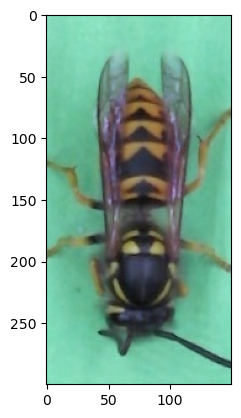

In [5]:
# Visualizes a single instance from the dataset
for input, label in dataset:
    break

example_index = 0

print(f'Label: {label[example_index].numpy()}')
plt.imshow(input[example_index]);

In [6]:
# Defines a simple convolutional network, but powerful enough that training should warm up the GPU a little.
n_outputs = len(ds_info.features['output'])

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='gelu', input_shape=(300, 150, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='gelu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='gelu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='gelu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='gelu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_outputs, activation='sigmoid'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 74, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 72, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 17, 64)       0

In [7]:
metrics = [
    tf.keras.metrics.BinaryAccuracy(),
    keras_gpu_metrics.gpu_utilization_metric(0),  # Assuming we have only one GPU and we are training on GPU 0
    keras_gpu_metrics.gpu_clock_speed_metric(0),
    keras_gpu_metrics.gpu_temperature_metric(0),
    keras_gpu_metrics.gpu_fan_speed_metric(0),
    keras_gpu_metrics.gpu_power_usage_metric(0),
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=metrics
)

In [8]:
history = model.fit(
    dataset,
    epochs=5,
    validation_data=dataset,
)

Epoch 1/5


ValueError: in user code:

    File "C:\Users\Daniel\.conda\envs\ecg-search\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Daniel\.conda\envs\ecg-search\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Daniel\.conda\envs\ecg-search\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Daniel\.conda\envs\ecg-search\lib\site-packages\keras\engine\training.py", line 998, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\Daniel\.conda\envs\ecg-search\lib\site-packages\keras\engine\training.py", line 1092, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\Daniel\.conda\envs\ecg-search\lib\site-packages\keras\engine\compile_utils.py", line 577, in update_state
        self.build(y_pred, y_true)
    File "C:\Users\Daniel\.conda\envs\ecg-search\lib\site-packages\keras\engine\compile_utils.py", line 506, in build
        self._set_metric_names()
    File "C:\Users\Daniel\.conda\envs\ecg-search\lib\site-packages\keras\engine\compile_utils.py", line 532, in _set_metric_names
        raise ValueError(

    ValueError: Found two metrics with the same name: metric. All the metrics added to the model need to have unique names.


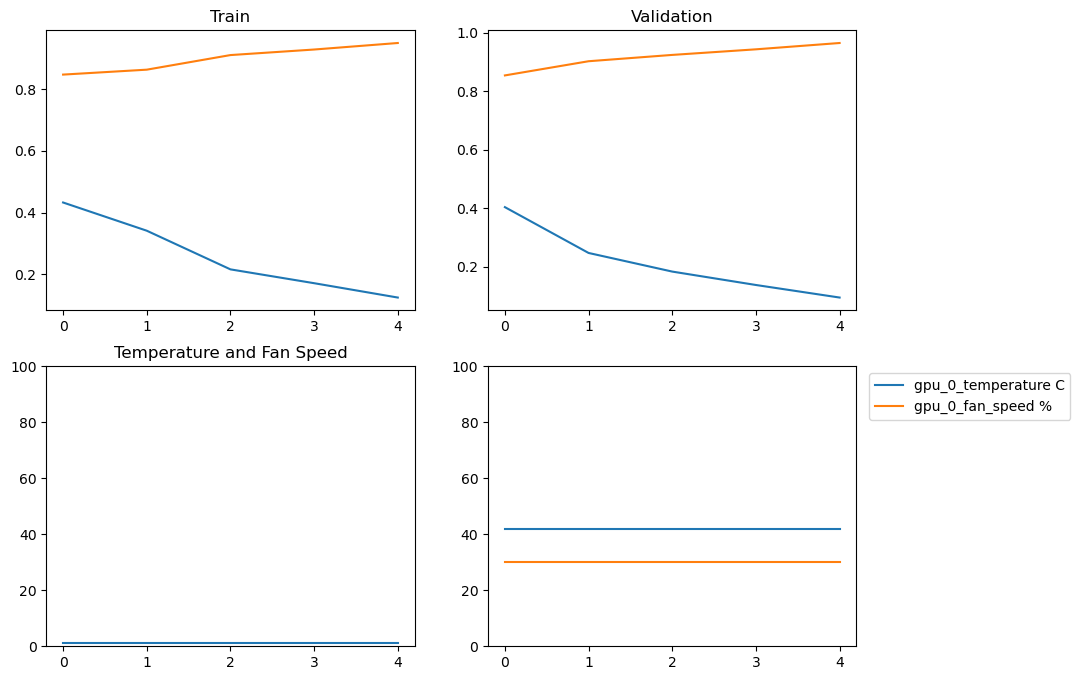

In [8]:
loss_history = history.history

fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0][0].set_title('Train')
ax[0][1].set_title('Validation')

ax[0][0].plot(loss_history['loss'], label='loss')
ax[0][0].plot(loss_history['binary_accuracy'], label='accuracy')
ax[0][1].plot(loss_history['val_loss'], label='loss')
ax[0][1].plot(loss_history['val_binary_accuracy'], label='accuracy')

ax[1][0].set_title('GPU Utilization %')
ax[1][0].plot(loss_history['gpu_0_utilization'], label='gpu_0_utilization %')
ax[1][0].set_ylim(0, 100)

ax[1][0].set_title('Temperature and Fan Speed')
ax[1][1].plot(loss_history['gpu_0_temperature'], label='gpu_0_temperature C')
ax[1][1].plot(loss_history['gpu_0_fan_speed'], label='gpu_0_fan_speed %')
ax[1][1].set_ylim(0, 100)

plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1.0))
plt.subplots_adjust(right=0.8)
plt.show();